In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip3 install torchinfo

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as tt
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import numpy as np
from PIL import ImageFile

%matplotlib inline

**GPU**

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

"""Move tensor(s) to chosen device"""
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
LEARNING_RATE = 5e-5
EPOCHS = 300
BATCH_SIZE = 64
IMAGE_SIZE = 64
LATENT_DIM = 128
CRITIC_ITER = 5
LAMBDA_GP = 10
LAMBDA_CLS = 1
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
latent_size = 128

device = get_default_device()
device
torch.manual_seed(0)

**Dataset Lookthrough**

In [ ]:
data_dir = 'new_dataset'
dataset = ImageFolder(data_dir)
print(len(dataset))
ImageFile.LOAD_TRUNCATED_IMAGES = True

17999


(78, 64)


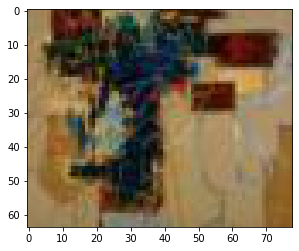

In [ ]:
img, label = dataset[2]
print(img.size)
plt.imshow(img)

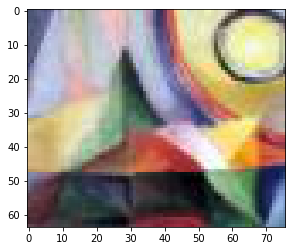

In [ ]:
img, label = dataset[750]
plt.imshow(img)

**Data preprocessing**
- resize to 64 x 64
- convert them to tensors and normalize them
- create dataloader
- look at sample

In [ ]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(IMAGE_SIZE),
    tt.CenterCrop(IMAGE_SIZE),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True, drop_last=True) # [128, 3, 64, 64]

In [ ]:
train_ds.class_to_idx

{'abstract': 0,
 'animal-painting': 1,
 'cityscape': 2,
 'figurative': 3,
 'flower-painting': 4,
 'genre-painting': 5,
 'landscape': 6,
 'marina': 7,
 'portrait': 8,
 'religious-painting': 9}

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    n_row = np.sqrt(nmax)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=n_row).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images.cpu(), nmax)
        print(images.shape)
        break

In [ ]:
# move data to GPU
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator Network**
- use a convolutional neural networks (CNN) which outputs a single number output for every image
- use stride of 2 to progressively reduce the size of the output feature map

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.disc = nn.Sequential(
          # in: 3 x 64 x 64
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
          nn.LeakyReLU(0.2),
          # out: 64 x 32 x 32

          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
          nn.InstanceNorm2d(128, affine=True),
          nn.LeakyReLU(0.2),
          # out: 128 x 16 x 16

          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
          nn.InstanceNorm2d(256, affine=True),
          nn.LeakyReLU(0.2),
          # out: 256 x 8 x 8

          nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
          nn.InstanceNorm2d(512, affine=True),
          nn.LeakyReLU(0.2),
          # out: 512 x 4 x 4
        )
        self.flat = nn.Flatten()

        self.finalLayer = nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0)

        self.aux_layer = nn.Sequential(
            nn.Linear(512*4*4, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
        )


    def forward(self, img):
        out = self.disc(img)

        validity = self.finalLayer(out)
        label = self.aux_layer(self.flat(out))
        return validity, label

In [ ]:
discriminator = Discriminator().to(device)
summary(discriminator, input_size=(128, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-1                       [128, 64, 32, 32]         3,136
│    └─LeakyReLU: 2-2                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 128, 16, 16]        131,072
│    └─InstanceNorm2d: 2-4               [128, 128, 16, 16]        256
│    └─LeakyReLU: 2-5                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-6                       [128, 256, 8, 8]          524,288
│    └─InstanceNorm2d: 2-7               [128, 256, 8, 8]          512
│    └─LeakyReLU: 2-8                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-9                       [128, 512, 4, 4]          2,097,152
│    └─InstanceNorm2d: 2-10              [128, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [128, 512, 4, 4]   

**Generator Network**
- input: a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image
- convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28 using the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_block = nn.Sequential(
        nn.ConvTranspose2d(latent_size + 10, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # 512, 4, 4

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # 256, 8, 8

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # 128, 16, 16

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 64, 32, 32

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
    )

  def forward(self, input):
    img = self.conv_block(input)

    return img

In [ ]:
generator = Generator().to(device)
summary(generator, input_size=[(128, 138, 1, 1)])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [128, 3, 64, 64]          --
│    └─ConvTranspose2d: 2-1              [128, 512, 4, 4]          1,130,496
│    └─BatchNorm2d: 2-2                  [128, 512, 4, 4]          1,024
│    └─ReLU: 2-3                         [128, 512, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 256, 8, 8]          2,097,152
│    └─BatchNorm2d: 2-5                  [128, 256, 8, 8]          512
│    └─ReLU: 2-6                         [128, 256, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 128, 16, 16]        524,288
│    └─BatchNorm2d: 2-8                  [128, 128, 16, 16]        256
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 64, 32, 32]         131,072
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 3

In [ ]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
  x = torch.randn(8, 3, 64, 64)
  disc = Discriminator()
  assert disc(x)[0].shape == (8, 1, 1, 1), "D failed"
  gen = Generator()
  z = torch.randn(8, 138, 1, 1)
  assert gen(z).shape == (8, 3, 64, 64), "gen failes"

In [ ]:
test()

In [ ]:
# gradient penalty
def gradient_penalty(critic, real, fake, device):
  batch, c, h, w = real.shape
  alpha = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
  interpolated_images = real * alpha + fake * (1 - alpha)

  mixed_scores, pred_cls = critic(interpolated_images)

  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph=True,
      retain_graph=True,
  )[0]
  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1)**2)

  return gradient_penalty

**Generated Images**

In [ ]:
date = '0418'
img_dir = date + '_plot'

In [ ]:
def save_samples(index, show=True):
  latent = torch.randn(100, latent_size, 1, 1).to(device)
  label = np.zeros((100,))
  for i in range(10):
    for j in range(10):
      label[10*i+j]=i
  label = torch.tensor(label, dtype=torch.int64).to(device)
  label = F.one_hot(label, 10).unsqueeze(-1).unsqueeze(-1)
  g_input = torch.cat((latent, label), dim=1)
  fake_images = generator(g_input)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

  save_image(denorm(fake_images), os.path.join(img_dir, fake_fname), nrow=10)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=10).permute(1, 2, 0))

In [ ]:
def save_model(index):
  g_name = f"g_model_{index}"
  d_name = f"d_model_{index}"

  g_path = os.path.join(img_dir, g_name)
  d_path = os.path.join(img_dir, d_name)

  torch.save(generator.state_dict(), g_path)
  torch.save(critic.state_dict(), d_path)
  return

Saving generated-images-0300.png


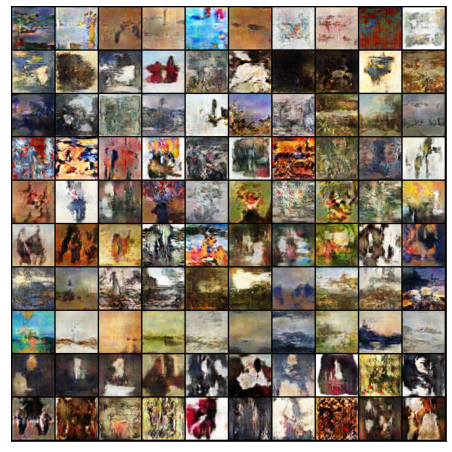

In [ ]:
save_model(300)
save_samples(300)

**Training the full loop**

In [ ]:
generator = Generator().to(device)
critic = Discriminator().to(device)
initialize_weights(generator)
initialize_weights(critic)

opt_g = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))
opt_d = torch.optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

In [ ]:
def fit(start_epoch, epochs, start_idx=1):
  torch.cuda.empty_cache()
  
  loss_in_train = {}

  for epoch in range(start_epoch, epochs):
    generator.train()
    critic.train()

    for i, (real_images, real_label) in enumerate(tqdm(train_dl)):
      # target
      real_images, real_label = real_images.to(device), real_label.to(device)
      
      # ------------------------
      # Update Discriminator
      # max E[critic(real)] - E[critic(fake)] - cross_entropy
      # ------------------------
      latent_noise = torch.randn(real_images.size(0), latent_size, 1, 1).to(device)
      fake_label = torch.randint(10, (real_images.size(0),)).to(device)
      fake_label_onehot = F.one_hot(fake_label, 10).unsqueeze(-1).unsqueeze(-1).to(device)
      G_net_input = torch.cat((latent_noise, fake_label_onehot), dim=1)
      fake_images = generator(G_net_input)

      c_real, cls_real = critic(real_images)
      c_fake, cls_fake = critic(fake_images)

      c_real_score = torch.mean(c_real.reshape(-1))
      c_fake_score = torch.mean(c_fake.reshape(-1))

      gp = gradient_penalty(critic, real_images, fake_images, device)
      cls_loss = F.cross_entropy(cls_real, real_label)
      loss_critic = (
          -c_real_score + c_fake_score + LAMBDA_GP*gp + LAMBDA_CLS*cls_loss
      )
      opt_d.zero_grad()
      loss_critic.backward(retain_graph=True)
      opt_d.step()

      loss_in_train['C/real_score'] = c_real_score.item()
      loss_in_train['C/class_err'] = cls_loss.item()

      # ------------------------
      # Update Generator
      # min -E[critic(fake)] + cross_entropy
      # ------------------------
      if i % CRITIC_ITER == 0:
        c_fake, cls_fake = critic(fake_images)
        
        fake_score = torch.mean(c_fake.reshape(-1))
        cls_loss = F.cross_entropy(cls_fake, fake_label)
        loss_gen = -fake_score + LAMBDA_CLS * cls_loss
        opt_g.zero_grad()
        loss_gen.backward()
        opt_g.step()

        loss_in_train['G/fake_score'] = fake_score.item()
        loss_in_train['G/class_err'] = cls_loss.item()
    
    real_scores.append(loss_in_train['C/real_score'])
    fake_scores.append(loss_in_train['G/fake_score'])
    real_cls_loss.append(loss_in_train['C/class_err'])
    fake_cls_loss.append(loss_in_train['G/class_err'])

    print("Epoch [{}/{}], real_score: {:.4f}, fake_score: {:.4f}, r_cls_err: {:.4f}, f_cls_err: {:.4f}".format(
          epoch+1, EPOCHS, real_scores[-1], fake_scores[-1], real_cls_loss[-1], fake_cls_loss[-1]))
    
    # evaluation
    with torch.no_grad():
      generator.eval()
      critic.eval()
      save_samples(epoch+start_idx, show=False)
    if (epoch+1) % 25 == 0:
      save_model(epoch+1)
    
  return 

In [ ]:
generator.load_state_dict(torch.load(f"0406_plot/g_model_300"))
critic.load_state_dict(torch.load(f"0406_plot/d_model_300"))

<All keys matched successfully>

In [ ]:
real_scores = []
fake_scores = []
real_cls_loss = []
fake_cls_loss = []
fit(300, 600)

  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [301/300], real_score: -125.6356, fake_score: -135.4424, r_cls_err: 0.0045, f_cls_err: 0.7745
Saving generated-images-0301.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [302/300], real_score: -121.2702, fake_score: -131.7704, r_cls_err: 0.0082, f_cls_err: 0.9735
Saving generated-images-0302.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [303/300], real_score: -120.6330, fake_score: -135.3283, r_cls_err: 0.0417, f_cls_err: 0.8116
Saving generated-images-0303.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [304/300], real_score: -120.1191, fake_score: -131.5512, r_cls_err: 0.0036, f_cls_err: 1.6290
Saving generated-images-0304.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [305/300], real_score: -122.3401, fake_score: -133.3663, r_cls_err: 0.0015, f_cls_err: 0.9343
Saving generated-images-0305.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [306/300], real_score: -122.6212, fake_score: -136.3118, r_cls_err: 0.1356, f_cls_err: 1.0771
Saving generated-images-0306.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [307/300], real_score: -122.5643, fake_score: -134.1657, r_cls_err: 0.0265, f_cls_err: 0.6667
Saving generated-images-0307.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [308/300], real_score: -118.3183, fake_score: -131.3062, r_cls_err: 0.0664, f_cls_err: 0.9253
Saving generated-images-0308.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [309/300], real_score: -119.6086, fake_score: -135.2604, r_cls_err: 0.0022, f_cls_err: 0.5404
Saving generated-images-0309.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [310/300], real_score: -114.5437, fake_score: -134.5071, r_cls_err: 0.0011, f_cls_err: 0.5061
Saving generated-images-0310.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [311/300], real_score: -124.5778, fake_score: -136.1503, r_cls_err: 0.0347, f_cls_err: 0.8545
Saving generated-images-0311.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [312/300], real_score: -121.8332, fake_score: -136.7005, r_cls_err: 0.0108, f_cls_err: 0.9123
Saving generated-images-0312.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [313/300], real_score: -123.6469, fake_score: -134.4856, r_cls_err: 0.0914, f_cls_err: 1.1139
Saving generated-images-0313.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [314/300], real_score: -120.4321, fake_score: -134.6469, r_cls_err: 0.0074, f_cls_err: 0.8579
Saving generated-images-0314.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [315/300], real_score: -123.5777, fake_score: -136.6680, r_cls_err: 0.1087, f_cls_err: 0.4942
Saving generated-images-0315.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [316/300], real_score: -126.0404, fake_score: -136.0591, r_cls_err: 0.0027, f_cls_err: 0.9225
Saving generated-images-0316.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [317/300], real_score: -119.2552, fake_score: -131.2967, r_cls_err: 0.1211, f_cls_err: 0.3141
Saving generated-images-0317.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [318/300], real_score: -121.6736, fake_score: -137.0522, r_cls_err: 0.0062, f_cls_err: 1.2254
Saving generated-images-0318.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [319/300], real_score: -123.2124, fake_score: -133.9238, r_cls_err: 0.1117, f_cls_err: 0.4899
Saving generated-images-0319.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [320/300], real_score: -126.7498, fake_score: -135.2382, r_cls_err: 0.0103, f_cls_err: 0.4825
Saving generated-images-0320.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [321/300], real_score: -120.3787, fake_score: -135.3321, r_cls_err: 0.0324, f_cls_err: 0.6020
Saving generated-images-0321.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [322/300], real_score: -125.7230, fake_score: -137.6373, r_cls_err: 0.0931, f_cls_err: 0.2665
Saving generated-images-0322.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [323/300], real_score: -120.7718, fake_score: -136.8961, r_cls_err: 0.0670, f_cls_err: 0.4908
Saving generated-images-0323.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [324/300], real_score: -121.0167, fake_score: -135.0585, r_cls_err: 0.1517, f_cls_err: 0.5883
Saving generated-images-0324.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [325/300], real_score: -126.8494, fake_score: -139.3711, r_cls_err: 0.1232, f_cls_err: 0.4382
Saving generated-images-0325.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [326/300], real_score: -128.8055, fake_score: -139.0868, r_cls_err: 0.0158, f_cls_err: 0.8846
Saving generated-images-0326.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [327/300], real_score: -124.2826, fake_score: -139.0652, r_cls_err: 0.0111, f_cls_err: 0.4676
Saving generated-images-0327.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [328/300], real_score: -125.5738, fake_score: -135.1670, r_cls_err: 0.1534, f_cls_err: 1.1544
Saving generated-images-0328.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [329/300], real_score: -122.0053, fake_score: -136.5054, r_cls_err: 0.0243, f_cls_err: 0.4333
Saving generated-images-0329.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [330/300], real_score: -125.4330, fake_score: -137.8860, r_cls_err: 0.0177, f_cls_err: 0.7006
Saving generated-images-0330.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [331/300], real_score: -120.7095, fake_score: -135.9473, r_cls_err: 0.0620, f_cls_err: 0.1626
Saving generated-images-0331.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [332/300], real_score: -125.0670, fake_score: -138.4913, r_cls_err: 0.0058, f_cls_err: 0.6717
Saving generated-images-0332.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [333/300], real_score: -123.3852, fake_score: -136.8994, r_cls_err: 0.0029, f_cls_err: 1.3418
Saving generated-images-0333.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [334/300], real_score: -125.6111, fake_score: -136.6770, r_cls_err: 0.1654, f_cls_err: 1.1493
Saving generated-images-0334.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [335/300], real_score: -130.3202, fake_score: -142.2386, r_cls_err: 0.0011, f_cls_err: 0.4943
Saving generated-images-0335.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [336/300], real_score: -125.2479, fake_score: -136.8357, r_cls_err: 0.0519, f_cls_err: 0.7538
Saving generated-images-0336.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [337/300], real_score: -123.9586, fake_score: -135.2659, r_cls_err: 0.0249, f_cls_err: 0.8166
Saving generated-images-0337.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [338/300], real_score: -125.5816, fake_score: -138.3932, r_cls_err: 0.0034, f_cls_err: 1.5205
Saving generated-images-0338.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [339/300], real_score: -128.6451, fake_score: -138.6844, r_cls_err: 0.0641, f_cls_err: 1.1987
Saving generated-images-0339.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [340/300], real_score: -125.0398, fake_score: -138.5185, r_cls_err: 0.0071, f_cls_err: 0.2067
Saving generated-images-0340.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [341/300], real_score: -125.8548, fake_score: -138.2178, r_cls_err: 0.0792, f_cls_err: 0.1300
Saving generated-images-0341.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [342/300], real_score: -128.6593, fake_score: -140.4005, r_cls_err: 0.1053, f_cls_err: 0.9335
Saving generated-images-0342.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [343/300], real_score: -125.6593, fake_score: -139.0520, r_cls_err: 0.0017, f_cls_err: 0.5780
Saving generated-images-0343.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [344/300], real_score: -128.8597, fake_score: -141.9090, r_cls_err: 0.1129, f_cls_err: 0.3919
Saving generated-images-0344.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [345/300], real_score: -128.0347, fake_score: -138.2633, r_cls_err: 0.1822, f_cls_err: 0.4768
Saving generated-images-0345.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [346/300], real_score: -123.5896, fake_score: -137.9394, r_cls_err: 0.1298, f_cls_err: 0.7292
Saving generated-images-0346.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [347/300], real_score: -121.9930, fake_score: -137.9318, r_cls_err: 0.0218, f_cls_err: 1.0522
Saving generated-images-0347.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [348/300], real_score: -125.1604, fake_score: -138.5653, r_cls_err: 0.1384, f_cls_err: 0.2703
Saving generated-images-0348.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [349/300], real_score: -130.8253, fake_score: -140.3177, r_cls_err: 0.0422, f_cls_err: 1.4742
Saving generated-images-0349.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [350/300], real_score: -131.2507, fake_score: -142.5732, r_cls_err: 0.0818, f_cls_err: 0.7334
Saving generated-images-0350.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [351/300], real_score: -131.3647, fake_score: -143.0518, r_cls_err: 0.1341, f_cls_err: 0.8309
Saving generated-images-0351.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [352/300], real_score: -128.3660, fake_score: -142.5833, r_cls_err: 0.0040, f_cls_err: 1.0083
Saving generated-images-0352.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [353/300], real_score: -127.8713, fake_score: -140.6502, r_cls_err: 0.0337, f_cls_err: 0.9268
Saving generated-images-0353.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [354/300], real_score: -126.8994, fake_score: -141.7588, r_cls_err: 0.0386, f_cls_err: 1.1014
Saving generated-images-0354.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [355/300], real_score: -132.8939, fake_score: -141.2592, r_cls_err: 0.0756, f_cls_err: 1.3117
Saving generated-images-0355.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [356/300], real_score: -128.6997, fake_score: -140.7596, r_cls_err: 0.0747, f_cls_err: 0.8576
Saving generated-images-0356.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [357/300], real_score: -132.0794, fake_score: -144.6425, r_cls_err: 0.0117, f_cls_err: 0.8450
Saving generated-images-0357.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [358/300], real_score: -129.0138, fake_score: -144.5543, r_cls_err: 0.0347, f_cls_err: 0.4107
Saving generated-images-0358.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [359/300], real_score: -127.8904, fake_score: -142.8931, r_cls_err: 0.0111, f_cls_err: 0.3943
Saving generated-images-0359.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [360/300], real_score: -135.0210, fake_score: -146.8249, r_cls_err: 0.0470, f_cls_err: 0.6097
Saving generated-images-0360.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [361/300], real_score: -132.1040, fake_score: -144.5738, r_cls_err: 0.0136, f_cls_err: 0.7115
Saving generated-images-0361.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [362/300], real_score: -131.4321, fake_score: -145.9304, r_cls_err: 0.0060, f_cls_err: 0.3777
Saving generated-images-0362.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [363/300], real_score: -136.3035, fake_score: -147.1838, r_cls_err: 0.0063, f_cls_err: 0.4198
Saving generated-images-0363.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [364/300], real_score: -130.9759, fake_score: -147.4342, r_cls_err: 0.0041, f_cls_err: 0.4224
Saving generated-images-0364.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [365/300], real_score: -136.7586, fake_score: -147.5882, r_cls_err: 0.0525, f_cls_err: 0.7880
Saving generated-images-0365.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [366/300], real_score: -137.4973, fake_score: -147.4432, r_cls_err: 0.0057, f_cls_err: 0.7188
Saving generated-images-0366.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [367/300], real_score: -133.3235, fake_score: -145.8128, r_cls_err: 0.0089, f_cls_err: 0.5853
Saving generated-images-0367.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [368/300], real_score: -137.8300, fake_score: -147.9760, r_cls_err: 0.0697, f_cls_err: 0.4428
Saving generated-images-0368.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [369/300], real_score: -132.8766, fake_score: -144.7966, r_cls_err: 0.0998, f_cls_err: 0.2112
Saving generated-images-0369.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [370/300], real_score: -135.8235, fake_score: -144.8499, r_cls_err: 0.0010, f_cls_err: 0.6503
Saving generated-images-0370.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [371/300], real_score: -136.3382, fake_score: -148.9265, r_cls_err: 0.0251, f_cls_err: 0.6640
Saving generated-images-0371.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [372/300], real_score: -133.6483, fake_score: -147.5582, r_cls_err: 0.1634, f_cls_err: 0.1304
Saving generated-images-0372.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [373/300], real_score: -126.9177, fake_score: -144.8344, r_cls_err: 0.0143, f_cls_err: 1.7260
Saving generated-images-0373.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [374/300], real_score: -139.1497, fake_score: -152.5601, r_cls_err: 0.0510, f_cls_err: 0.4438
Saving generated-images-0374.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [375/300], real_score: -136.0745, fake_score: -147.7323, r_cls_err: 0.0044, f_cls_err: 0.8255
Saving generated-images-0375.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [376/300], real_score: -133.1062, fake_score: -146.1545, r_cls_err: 0.0028, f_cls_err: 0.4287
Saving generated-images-0376.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [377/300], real_score: -139.3480, fake_score: -151.5793, r_cls_err: 0.0006, f_cls_err: 0.6704
Saving generated-images-0377.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [378/300], real_score: -135.6736, fake_score: -147.0892, r_cls_err: 0.1865, f_cls_err: 0.5631
Saving generated-images-0378.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [379/300], real_score: -136.7265, fake_score: -146.0548, r_cls_err: 0.0043, f_cls_err: 0.5495
Saving generated-images-0379.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [380/300], real_score: -130.2673, fake_score: -144.9959, r_cls_err: 0.0004, f_cls_err: 0.3328
Saving generated-images-0380.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [381/300], real_score: -136.9720, fake_score: -149.3095, r_cls_err: 0.0050, f_cls_err: 0.5338
Saving generated-images-0381.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [382/300], real_score: -136.0245, fake_score: -146.8578, r_cls_err: 0.0739, f_cls_err: 0.7046
Saving generated-images-0382.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [383/300], real_score: -140.6232, fake_score: -152.6754, r_cls_err: 0.0020, f_cls_err: 0.5847
Saving generated-images-0383.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [384/300], real_score: -133.9830, fake_score: -145.5953, r_cls_err: 0.0579, f_cls_err: 0.5041
Saving generated-images-0384.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [385/300], real_score: -132.5673, fake_score: -145.7182, r_cls_err: 0.0043, f_cls_err: 1.1107
Saving generated-images-0385.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [386/300], real_score: -139.7186, fake_score: -151.3200, r_cls_err: 0.0752, f_cls_err: 0.1926
Saving generated-images-0386.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [387/300], real_score: -137.5448, fake_score: -148.4755, r_cls_err: 0.0216, f_cls_err: 0.6702
Saving generated-images-0387.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [388/300], real_score: -134.8282, fake_score: -150.2946, r_cls_err: 0.0155, f_cls_err: 0.2816
Saving generated-images-0388.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [389/300], real_score: -134.2078, fake_score: -145.4910, r_cls_err: 0.0363, f_cls_err: 0.7782
Saving generated-images-0389.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [390/300], real_score: -136.0696, fake_score: -149.2703, r_cls_err: 0.0132, f_cls_err: 0.8322
Saving generated-images-0390.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [391/300], real_score: -139.4588, fake_score: -150.7458, r_cls_err: 0.0155, f_cls_err: 1.4032
Saving generated-images-0391.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [392/300], real_score: -137.0036, fake_score: -149.2593, r_cls_err: 0.0008, f_cls_err: 0.2359
Saving generated-images-0392.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [393/300], real_score: -136.8810, fake_score: -151.8325, r_cls_err: 0.2617, f_cls_err: 0.5486
Saving generated-images-0393.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [394/300], real_score: -136.3685, fake_score: -150.9028, r_cls_err: 0.1516, f_cls_err: 0.6650
Saving generated-images-0394.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [395/300], real_score: -139.1603, fake_score: -150.0213, r_cls_err: 0.0727, f_cls_err: 1.3421
Saving generated-images-0395.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [396/300], real_score: -138.4273, fake_score: -150.6652, r_cls_err: 0.0003, f_cls_err: 0.6888
Saving generated-images-0396.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [397/300], real_score: -139.9362, fake_score: -151.0772, r_cls_err: 0.0241, f_cls_err: 1.2898
Saving generated-images-0397.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [398/300], real_score: -142.9137, fake_score: -154.5615, r_cls_err: 0.0379, f_cls_err: 0.6805
Saving generated-images-0398.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [399/300], real_score: -139.2435, fake_score: -151.1231, r_cls_err: 0.0295, f_cls_err: 0.5626
Saving generated-images-0399.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [400/300], real_score: -135.8792, fake_score: -149.3647, r_cls_err: 0.0007, f_cls_err: 1.2560
Saving generated-images-0400.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [401/300], real_score: -138.3022, fake_score: -150.9567, r_cls_err: 0.0007, f_cls_err: 0.6208
Saving generated-images-0401.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [402/300], real_score: -139.9766, fake_score: -150.0851, r_cls_err: 0.0236, f_cls_err: 1.9550
Saving generated-images-0402.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [403/300], real_score: -142.6993, fake_score: -155.0021, r_cls_err: 0.0721, f_cls_err: 0.5468
Saving generated-images-0403.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [404/300], real_score: -134.4855, fake_score: -150.1324, r_cls_err: 0.0024, f_cls_err: 0.7017
Saving generated-images-0404.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [405/300], real_score: -136.8737, fake_score: -149.7349, r_cls_err: 0.0015, f_cls_err: 1.0846
Saving generated-images-0405.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [406/300], real_score: -138.0902, fake_score: -151.8079, r_cls_err: 0.0397, f_cls_err: 0.4135
Saving generated-images-0406.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [407/300], real_score: -135.9895, fake_score: -150.7955, r_cls_err: 0.0012, f_cls_err: 0.4158
Saving generated-images-0407.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [408/300], real_score: -138.9813, fake_score: -154.5582, r_cls_err: 0.0566, f_cls_err: 0.3156
Saving generated-images-0408.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [409/300], real_score: -139.8349, fake_score: -152.9578, r_cls_err: 0.1482, f_cls_err: 0.5484
Saving generated-images-0409.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [410/300], real_score: -138.5482, fake_score: -150.3724, r_cls_err: 0.0207, f_cls_err: 0.7016
Saving generated-images-0410.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [411/300], real_score: -137.0287, fake_score: -151.7840, r_cls_err: 0.3774, f_cls_err: 0.8505
Saving generated-images-0411.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [412/300], real_score: -136.8414, fake_score: -151.8624, r_cls_err: 0.0272, f_cls_err: 1.5881
Saving generated-images-0412.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [413/300], real_score: -135.9878, fake_score: -151.3596, r_cls_err: 0.0500, f_cls_err: 1.1220
Saving generated-images-0413.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [414/300], real_score: -142.2816, fake_score: -154.2275, r_cls_err: 0.0081, f_cls_err: 0.7159
Saving generated-images-0414.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [415/300], real_score: -137.7807, fake_score: -152.3979, r_cls_err: 0.0181, f_cls_err: 0.4888
Saving generated-images-0415.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [416/300], real_score: -140.8243, fake_score: -155.1069, r_cls_err: 0.0206, f_cls_err: 1.7819
Saving generated-images-0416.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [417/300], real_score: -142.3391, fake_score: -156.3759, r_cls_err: 0.0058, f_cls_err: 0.7588
Saving generated-images-0417.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [418/300], real_score: -138.6554, fake_score: -151.6106, r_cls_err: 0.1239, f_cls_err: 0.9412
Saving generated-images-0418.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [419/300], real_score: -143.6476, fake_score: -157.7983, r_cls_err: 0.0030, f_cls_err: 0.9431
Saving generated-images-0419.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [420/300], real_score: -144.1400, fake_score: -155.7000, r_cls_err: 0.0005, f_cls_err: 1.0958
Saving generated-images-0420.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [421/300], real_score: -134.7289, fake_score: -149.4117, r_cls_err: 0.0047, f_cls_err: 0.7200
Saving generated-images-0421.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [422/300], real_score: -145.4712, fake_score: -157.3669, r_cls_err: 0.0129, f_cls_err: 0.3367
Saving generated-images-0422.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [423/300], real_score: -144.0019, fake_score: -156.2035, r_cls_err: 0.0190, f_cls_err: 1.2259
Saving generated-images-0423.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [424/300], real_score: -147.0771, fake_score: -156.4545, r_cls_err: 0.0232, f_cls_err: 0.9000
Saving generated-images-0424.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [425/300], real_score: -144.8721, fake_score: -153.0470, r_cls_err: 0.0891, f_cls_err: 0.8066
Saving generated-images-0425.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [426/300], real_score: -140.3287, fake_score: -153.5916, r_cls_err: 0.0034, f_cls_err: 0.7733
Saving generated-images-0426.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [427/300], real_score: -142.2568, fake_score: -155.4450, r_cls_err: 0.1818, f_cls_err: 1.1466
Saving generated-images-0427.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [428/300], real_score: -141.3124, fake_score: -156.3908, r_cls_err: 0.0012, f_cls_err: 0.6663
Saving generated-images-0428.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [429/300], real_score: -140.6488, fake_score: -151.4730, r_cls_err: 0.0154, f_cls_err: 0.5944
Saving generated-images-0429.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [430/300], real_score: -138.6492, fake_score: -152.9510, r_cls_err: 0.0122, f_cls_err: 1.1474
Saving generated-images-0430.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [431/300], real_score: -143.1232, fake_score: -155.1427, r_cls_err: 0.0120, f_cls_err: 1.7551
Saving generated-images-0431.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [432/300], real_score: -142.9937, fake_score: -157.9926, r_cls_err: 0.0235, f_cls_err: 1.0101
Saving generated-images-0432.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [433/300], real_score: -144.1801, fake_score: -158.3633, r_cls_err: 0.0445, f_cls_err: 0.2683
Saving generated-images-0433.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [434/300], real_score: -150.5607, fake_score: -163.6049, r_cls_err: 0.0015, f_cls_err: 0.6209
Saving generated-images-0434.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [435/300], real_score: -142.8980, fake_score: -157.1512, r_cls_err: 0.0010, f_cls_err: 1.1169
Saving generated-images-0435.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [436/300], real_score: -145.6805, fake_score: -160.4183, r_cls_err: 0.0025, f_cls_err: 0.5174
Saving generated-images-0436.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [437/300], real_score: -143.7912, fake_score: -157.9806, r_cls_err: 0.1934, f_cls_err: 0.2894
Saving generated-images-0437.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [438/300], real_score: -145.6567, fake_score: -158.0302, r_cls_err: 0.0087, f_cls_err: 0.8422
Saving generated-images-0438.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [439/300], real_score: -143.1956, fake_score: -158.0815, r_cls_err: 0.2699, f_cls_err: 0.9280
Saving generated-images-0439.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [440/300], real_score: -144.2644, fake_score: -156.5835, r_cls_err: 0.0127, f_cls_err: 0.2511
Saving generated-images-0440.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [441/300], real_score: -145.4826, fake_score: -158.7827, r_cls_err: 0.0048, f_cls_err: 0.2945
Saving generated-images-0441.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [442/300], real_score: -144.6311, fake_score: -158.9097, r_cls_err: 0.0795, f_cls_err: 0.4852
Saving generated-images-0442.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [443/300], real_score: -146.5693, fake_score: -160.7352, r_cls_err: 0.0398, f_cls_err: 0.8109
Saving generated-images-0443.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [444/300], real_score: -144.9899, fake_score: -158.1724, r_cls_err: 0.0098, f_cls_err: 0.2582
Saving generated-images-0444.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [445/300], real_score: -148.4728, fake_score: -161.6022, r_cls_err: 0.0020, f_cls_err: 0.4272
Saving generated-images-0445.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [446/300], real_score: -150.2035, fake_score: -162.9928, r_cls_err: 0.0074, f_cls_err: 0.2209
Saving generated-images-0446.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [447/300], real_score: -142.2063, fake_score: -158.7228, r_cls_err: 0.1022, f_cls_err: 0.8879
Saving generated-images-0447.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [448/300], real_score: -149.5846, fake_score: -163.6130, r_cls_err: 0.0025, f_cls_err: 0.5853
Saving generated-images-0448.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [449/300], real_score: -145.6031, fake_score: -159.9320, r_cls_err: 0.0036, f_cls_err: 0.2154
Saving generated-images-0449.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [450/300], real_score: -141.2644, fake_score: -158.4754, r_cls_err: 0.1625, f_cls_err: 0.3613
Saving generated-images-0450.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [451/300], real_score: -147.5585, fake_score: -162.1390, r_cls_err: 0.0003, f_cls_err: 0.2170
Saving generated-images-0451.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [452/300], real_score: -150.2864, fake_score: -160.2168, r_cls_err: 0.0092, f_cls_err: 0.5036
Saving generated-images-0452.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [453/300], real_score: -150.9054, fake_score: -164.0312, r_cls_err: 0.0119, f_cls_err: 0.0954
Saving generated-images-0453.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [454/300], real_score: -146.4483, fake_score: -159.8059, r_cls_err: 0.0636, f_cls_err: 0.5823
Saving generated-images-0454.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [455/300], real_score: -148.1328, fake_score: -163.9263, r_cls_err: 0.0454, f_cls_err: 0.9137
Saving generated-images-0455.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [456/300], real_score: -146.8146, fake_score: -162.0716, r_cls_err: 0.0028, f_cls_err: 1.3666
Saving generated-images-0456.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [457/300], real_score: -149.3633, fake_score: -164.3319, r_cls_err: 0.0028, f_cls_err: 0.2763
Saving generated-images-0457.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [458/300], real_score: -146.1924, fake_score: -164.4616, r_cls_err: 0.0302, f_cls_err: 0.6910
Saving generated-images-0458.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [459/300], real_score: -147.6615, fake_score: -160.7419, r_cls_err: 0.0165, f_cls_err: 0.6424
Saving generated-images-0459.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [460/300], real_score: -153.1465, fake_score: -165.7538, r_cls_err: 0.0007, f_cls_err: 0.3093
Saving generated-images-0460.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [461/300], real_score: -150.1168, fake_score: -166.3465, r_cls_err: 0.0013, f_cls_err: 0.4469
Saving generated-images-0461.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [462/300], real_score: -149.0396, fake_score: -162.3870, r_cls_err: 0.0502, f_cls_err: 1.0889
Saving generated-images-0462.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [463/300], real_score: -147.6637, fake_score: -162.9824, r_cls_err: 0.0484, f_cls_err: 0.8371
Saving generated-images-0463.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [464/300], real_score: -151.7174, fake_score: -165.4117, r_cls_err: 0.0041, f_cls_err: 0.9464
Saving generated-images-0464.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [465/300], real_score: -153.3467, fake_score: -166.2699, r_cls_err: 0.0027, f_cls_err: 0.6371
Saving generated-images-0465.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [466/300], real_score: -148.4997, fake_score: -163.6416, r_cls_err: 0.0059, f_cls_err: 2.0538
Saving generated-images-0466.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [467/300], real_score: -146.9686, fake_score: -159.5001, r_cls_err: 0.0260, f_cls_err: 1.0100
Saving generated-images-0467.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [468/300], real_score: -152.0282, fake_score: -165.0914, r_cls_err: 0.0403, f_cls_err: 0.6983
Saving generated-images-0468.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [469/300], real_score: -158.0501, fake_score: -169.7258, r_cls_err: 0.0094, f_cls_err: 0.6203
Saving generated-images-0469.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [470/300], real_score: -151.9992, fake_score: -166.1378, r_cls_err: 0.0004, f_cls_err: 1.0267
Saving generated-images-0470.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [471/300], real_score: -158.4579, fake_score: -168.7340, r_cls_err: 0.0024, f_cls_err: 0.4814
Saving generated-images-0471.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [472/300], real_score: -153.9297, fake_score: -165.3477, r_cls_err: 0.0142, f_cls_err: 0.5600
Saving generated-images-0472.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [473/300], real_score: -158.5101, fake_score: -171.3871, r_cls_err: 0.0424, f_cls_err: 0.5055
Saving generated-images-0473.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [474/300], real_score: -150.8432, fake_score: -168.4643, r_cls_err: 0.0090, f_cls_err: 0.2957
Saving generated-images-0474.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [475/300], real_score: -150.8717, fake_score: -165.8102, r_cls_err: 0.0016, f_cls_err: 0.4292
Saving generated-images-0475.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [476/300], real_score: -153.2262, fake_score: -166.5914, r_cls_err: 0.1232, f_cls_err: 1.4587
Saving generated-images-0476.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [477/300], real_score: -156.0835, fake_score: -166.5054, r_cls_err: 0.1992, f_cls_err: 0.8885
Saving generated-images-0477.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [478/300], real_score: -151.4597, fake_score: -166.8424, r_cls_err: 0.2628, f_cls_err: 0.3031
Saving generated-images-0478.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [479/300], real_score: -158.3964, fake_score: -170.4792, r_cls_err: 0.0152, f_cls_err: 1.9720
Saving generated-images-0479.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [480/300], real_score: -152.1971, fake_score: -166.0413, r_cls_err: 0.0345, f_cls_err: 1.1365
Saving generated-images-0480.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [481/300], real_score: -153.8427, fake_score: -166.3459, r_cls_err: 0.0010, f_cls_err: 0.6131
Saving generated-images-0481.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [482/300], real_score: -153.7398, fake_score: -167.2417, r_cls_err: 0.0020, f_cls_err: 0.6362
Saving generated-images-0482.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [483/300], real_score: -153.0200, fake_score: -166.6634, r_cls_err: 0.0005, f_cls_err: 1.1590
Saving generated-images-0483.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [484/300], real_score: -151.9784, fake_score: -166.8572, r_cls_err: 0.2669, f_cls_err: 0.2475
Saving generated-images-0484.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [485/300], real_score: -146.6688, fake_score: -161.6514, r_cls_err: 0.0003, f_cls_err: 0.8386
Saving generated-images-0485.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [486/300], real_score: -153.3814, fake_score: -169.8999, r_cls_err: 0.0552, f_cls_err: 0.4155
Saving generated-images-0486.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [487/300], real_score: -159.4286, fake_score: -170.7189, r_cls_err: 0.0595, f_cls_err: 0.3599
Saving generated-images-0487.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [488/300], real_score: -154.9991, fake_score: -171.0260, r_cls_err: 0.0705, f_cls_err: 0.4200
Saving generated-images-0488.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [489/300], real_score: -154.5685, fake_score: -170.4576, r_cls_err: 0.2099, f_cls_err: 1.2807
Saving generated-images-0489.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [490/300], real_score: -161.1613, fake_score: -171.7688, r_cls_err: 0.2182, f_cls_err: 1.8951
Saving generated-images-0490.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [491/300], real_score: -159.5623, fake_score: -171.6226, r_cls_err: 0.0042, f_cls_err: 1.0265
Saving generated-images-0491.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [492/300], real_score: -158.1590, fake_score: -170.7293, r_cls_err: 0.1791, f_cls_err: 0.1858
Saving generated-images-0492.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [493/300], real_score: -158.2259, fake_score: -173.8883, r_cls_err: 0.0138, f_cls_err: 0.5764
Saving generated-images-0493.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [494/300], real_score: -160.7648, fake_score: -172.8917, r_cls_err: 0.0241, f_cls_err: 0.1270
Saving generated-images-0494.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [495/300], real_score: -159.7133, fake_score: -173.5261, r_cls_err: 0.0123, f_cls_err: 0.4266
Saving generated-images-0495.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [496/300], real_score: -160.2183, fake_score: -172.0019, r_cls_err: 0.0141, f_cls_err: 0.7454
Saving generated-images-0496.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [497/300], real_score: -158.6556, fake_score: -168.7368, r_cls_err: 0.1180, f_cls_err: 0.7605
Saving generated-images-0497.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [498/300], real_score: -159.1716, fake_score: -171.5850, r_cls_err: 0.0003, f_cls_err: 0.2879
Saving generated-images-0498.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [499/300], real_score: -158.7245, fake_score: -172.3701, r_cls_err: 0.0170, f_cls_err: 0.2532
Saving generated-images-0499.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [500/300], real_score: -158.9068, fake_score: -171.2390, r_cls_err: 0.0800, f_cls_err: 0.7276
Saving generated-images-0500.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [501/300], real_score: -153.8218, fake_score: -169.5103, r_cls_err: 0.0001, f_cls_err: 0.2998
Saving generated-images-0501.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [502/300], real_score: -162.1225, fake_score: -175.8834, r_cls_err: 0.0047, f_cls_err: 0.5367
Saving generated-images-0502.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [503/300], real_score: -160.0225, fake_score: -173.1345, r_cls_err: 0.0029, f_cls_err: 0.3827
Saving generated-images-0503.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [504/300], real_score: -156.5919, fake_score: -169.0012, r_cls_err: 0.0922, f_cls_err: 1.0276
Saving generated-images-0504.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [505/300], real_score: -161.1818, fake_score: -175.5194, r_cls_err: 0.0348, f_cls_err: 1.3457
Saving generated-images-0505.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [506/300], real_score: -157.9853, fake_score: -172.1706, r_cls_err: 0.2379, f_cls_err: 0.2199
Saving generated-images-0506.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [507/300], real_score: -161.9788, fake_score: -173.4430, r_cls_err: 0.0013, f_cls_err: 0.9302
Saving generated-images-0507.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [508/300], real_score: -160.8584, fake_score: -173.4786, r_cls_err: 0.0124, f_cls_err: 0.3927
Saving generated-images-0508.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [509/300], real_score: -160.3140, fake_score: -171.5837, r_cls_err: 0.1152, f_cls_err: 1.7017
Saving generated-images-0509.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [510/300], real_score: -158.4016, fake_score: -173.8052, r_cls_err: 0.0122, f_cls_err: 0.7763
Saving generated-images-0510.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [511/300], real_score: -160.4315, fake_score: -170.6446, r_cls_err: 0.0691, f_cls_err: 0.8489
Saving generated-images-0511.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [512/300], real_score: -161.9260, fake_score: -175.1516, r_cls_err: 0.0384, f_cls_err: 0.3071
Saving generated-images-0512.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [513/300], real_score: -158.9363, fake_score: -174.2047, r_cls_err: 0.0006, f_cls_err: 1.7143
Saving generated-images-0513.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [514/300], real_score: -164.3583, fake_score: -177.8000, r_cls_err: 0.0050, f_cls_err: 1.0534
Saving generated-images-0514.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [515/300], real_score: -152.6590, fake_score: -172.7924, r_cls_err: 0.0006, f_cls_err: 1.2176
Saving generated-images-0515.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [516/300], real_score: -157.1573, fake_score: -170.9104, r_cls_err: 0.0726, f_cls_err: 0.7872
Saving generated-images-0516.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [517/300], real_score: -160.6568, fake_score: -176.7659, r_cls_err: 0.0049, f_cls_err: 0.5443
Saving generated-images-0517.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [518/300], real_score: -159.6150, fake_score: -174.2736, r_cls_err: 0.0857, f_cls_err: 1.7156
Saving generated-images-0518.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [519/300], real_score: -167.1821, fake_score: -178.3582, r_cls_err: 0.0325, f_cls_err: 0.6052
Saving generated-images-0519.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [520/300], real_score: -162.6086, fake_score: -177.3284, r_cls_err: 0.0202, f_cls_err: 0.3017
Saving generated-images-0520.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [521/300], real_score: -162.4854, fake_score: -177.0085, r_cls_err: 0.0003, f_cls_err: 0.3277
Saving generated-images-0521.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [522/300], real_score: -164.7341, fake_score: -176.3879, r_cls_err: 0.0003, f_cls_err: 1.3206
Saving generated-images-0522.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [523/300], real_score: -159.0719, fake_score: -174.6874, r_cls_err: 0.0082, f_cls_err: 0.8072
Saving generated-images-0523.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [524/300], real_score: -161.5795, fake_score: -177.4564, r_cls_err: 0.1711, f_cls_err: 0.5701
Saving generated-images-0524.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [525/300], real_score: -162.4747, fake_score: -176.0736, r_cls_err: 0.0471, f_cls_err: 0.7073
Saving generated-images-0525.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [526/300], real_score: -161.5873, fake_score: -177.0517, r_cls_err: 0.2084, f_cls_err: 0.7330
Saving generated-images-0526.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [527/300], real_score: -161.7475, fake_score: -178.7917, r_cls_err: 0.0421, f_cls_err: 0.6392
Saving generated-images-0527.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [528/300], real_score: -166.2639, fake_score: -179.7951, r_cls_err: 0.0134, f_cls_err: 0.4807
Saving generated-images-0528.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [529/300], real_score: -164.8998, fake_score: -177.6443, r_cls_err: 0.0013, f_cls_err: 0.9989
Saving generated-images-0529.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [530/300], real_score: -169.0309, fake_score: -181.5729, r_cls_err: 0.0000, f_cls_err: 0.2233
Saving generated-images-0530.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [531/300], real_score: -164.3825, fake_score: -182.6749, r_cls_err: 0.0072, f_cls_err: 0.9537
Saving generated-images-0531.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [532/300], real_score: -167.8063, fake_score: -178.9603, r_cls_err: 0.2997, f_cls_err: 1.4949
Saving generated-images-0532.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [533/300], real_score: -165.1484, fake_score: -176.7606, r_cls_err: 0.0179, f_cls_err: 0.4930
Saving generated-images-0533.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [534/300], real_score: -167.7236, fake_score: -182.6207, r_cls_err: 0.0281, f_cls_err: 0.4615
Saving generated-images-0534.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [535/300], real_score: -165.0688, fake_score: -181.6500, r_cls_err: 0.0356, f_cls_err: 0.2754
Saving generated-images-0535.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [536/300], real_score: -167.0677, fake_score: -178.0429, r_cls_err: 0.0024, f_cls_err: 0.5502
Saving generated-images-0536.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [537/300], real_score: -168.5703, fake_score: -181.7388, r_cls_err: 0.1405, f_cls_err: 0.6328
Saving generated-images-0537.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [538/300], real_score: -169.0539, fake_score: -180.0079, r_cls_err: 0.0125, f_cls_err: 1.1834
Saving generated-images-0538.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [539/300], real_score: -168.2911, fake_score: -183.0031, r_cls_err: 0.0008, f_cls_err: 0.5245
Saving generated-images-0539.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [540/300], real_score: -159.9422, fake_score: -178.3688, r_cls_err: 0.0010, f_cls_err: 1.2622
Saving generated-images-0540.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [541/300], real_score: -164.6913, fake_score: -178.6754, r_cls_err: 0.0000, f_cls_err: 0.7519
Saving generated-images-0541.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [542/300], real_score: -165.6559, fake_score: -180.5265, r_cls_err: 0.0741, f_cls_err: 0.9285
Saving generated-images-0542.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [543/300], real_score: -161.0799, fake_score: -178.8771, r_cls_err: 0.0045, f_cls_err: 1.1900
Saving generated-images-0543.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [544/300], real_score: -163.5538, fake_score: -178.0558, r_cls_err: 0.0009, f_cls_err: 0.4414
Saving generated-images-0544.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [545/300], real_score: -169.0428, fake_score: -179.7202, r_cls_err: 0.0742, f_cls_err: 0.9396
Saving generated-images-0545.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [546/300], real_score: -164.3314, fake_score: -179.1511, r_cls_err: 0.1058, f_cls_err: 1.0704
Saving generated-images-0546.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [547/300], real_score: -166.3896, fake_score: -184.7943, r_cls_err: 0.0105, f_cls_err: 0.7153
Saving generated-images-0547.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [548/300], real_score: -170.9275, fake_score: -183.7002, r_cls_err: 0.0267, f_cls_err: 1.1470
Saving generated-images-0548.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [549/300], real_score: -172.5018, fake_score: -184.0392, r_cls_err: 0.0006, f_cls_err: 0.2458
Saving generated-images-0549.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [550/300], real_score: -173.6295, fake_score: -185.1288, r_cls_err: 0.0132, f_cls_err: 0.1302
Saving generated-images-0550.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [551/300], real_score: -164.7042, fake_score: -180.6857, r_cls_err: 0.0489, f_cls_err: 1.3208
Saving generated-images-0551.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [552/300], real_score: -169.9743, fake_score: -182.7576, r_cls_err: 0.0465, f_cls_err: 0.8464
Saving generated-images-0552.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [553/300], real_score: -174.3096, fake_score: -185.9885, r_cls_err: 0.0005, f_cls_err: 0.2484
Saving generated-images-0553.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [554/300], real_score: -171.5209, fake_score: -186.1523, r_cls_err: 0.0884, f_cls_err: 1.7768
Saving generated-images-0554.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [555/300], real_score: -174.3157, fake_score: -185.3615, r_cls_err: 0.0013, f_cls_err: 0.5254
Saving generated-images-0555.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [556/300], real_score: -172.6829, fake_score: -186.8238, r_cls_err: 0.2474, f_cls_err: 1.2338
Saving generated-images-0556.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [557/300], real_score: -178.5101, fake_score: -187.9430, r_cls_err: 0.0007, f_cls_err: 0.1255
Saving generated-images-0557.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [558/300], real_score: -170.5595, fake_score: -184.0822, r_cls_err: 0.0379, f_cls_err: 1.0741
Saving generated-images-0558.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [559/300], real_score: -168.6557, fake_score: -180.6686, r_cls_err: 0.0130, f_cls_err: 1.2334
Saving generated-images-0559.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [560/300], real_score: -175.0432, fake_score: -187.3664, r_cls_err: 0.0061, f_cls_err: 0.3541
Saving generated-images-0560.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [561/300], real_score: -178.8736, fake_score: -192.4828, r_cls_err: 0.1916, f_cls_err: 1.4646
Saving generated-images-0561.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [562/300], real_score: -176.1310, fake_score: -188.5907, r_cls_err: 0.1197, f_cls_err: 0.4494
Saving generated-images-0562.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [563/300], real_score: -174.4521, fake_score: -185.8207, r_cls_err: 0.0154, f_cls_err: 0.6548
Saving generated-images-0563.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [564/300], real_score: -179.0031, fake_score: -191.8287, r_cls_err: 0.0669, f_cls_err: 1.1388
Saving generated-images-0564.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [565/300], real_score: -172.1921, fake_score: -187.4184, r_cls_err: 0.0084, f_cls_err: 0.5141
Saving generated-images-0565.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [566/300], real_score: -173.1310, fake_score: -187.3804, r_cls_err: 0.0031, f_cls_err: 1.5095
Saving generated-images-0566.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [567/300], real_score: -171.8088, fake_score: -187.1983, r_cls_err: 0.0006, f_cls_err: 2.2611
Saving generated-images-0567.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [568/300], real_score: -176.1110, fake_score: -189.9516, r_cls_err: 0.0137, f_cls_err: 1.1581
Saving generated-images-0568.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [569/300], real_score: -176.2538, fake_score: -189.8955, r_cls_err: 0.0008, f_cls_err: 1.7191
Saving generated-images-0569.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [570/300], real_score: -175.9364, fake_score: -189.7523, r_cls_err: 0.0029, f_cls_err: 0.3311
Saving generated-images-0570.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [571/300], real_score: -176.3007, fake_score: -192.2990, r_cls_err: 0.0088, f_cls_err: 0.7714
Saving generated-images-0571.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [572/300], real_score: -181.1539, fake_score: -191.5008, r_cls_err: 0.0007, f_cls_err: 0.4058
Saving generated-images-0572.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [573/300], real_score: -175.8833, fake_score: -190.3896, r_cls_err: 0.0038, f_cls_err: 0.1953
Saving generated-images-0573.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [574/300], real_score: -174.8682, fake_score: -190.2416, r_cls_err: 0.0003, f_cls_err: 0.5957
Saving generated-images-0574.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [575/300], real_score: -173.3821, fake_score: -189.6763, r_cls_err: 0.0008, f_cls_err: 1.6560
Saving generated-images-0575.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [576/300], real_score: -181.5210, fake_score: -193.1162, r_cls_err: 0.0001, f_cls_err: 1.3827
Saving generated-images-0576.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [577/300], real_score: -170.4648, fake_score: -188.2347, r_cls_err: 0.0054, f_cls_err: 1.1941
Saving generated-images-0577.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [578/300], real_score: -176.9388, fake_score: -190.8901, r_cls_err: 0.0432, f_cls_err: 1.0396
Saving generated-images-0578.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [579/300], real_score: -174.6783, fake_score: -188.0483, r_cls_err: 0.0148, f_cls_err: 0.8675
Saving generated-images-0579.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [580/300], real_score: -172.6671, fake_score: -191.6968, r_cls_err: 0.0084, f_cls_err: 1.0019
Saving generated-images-0580.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [581/300], real_score: -176.2896, fake_score: -189.6222, r_cls_err: 0.0011, f_cls_err: 0.7184
Saving generated-images-0581.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [582/300], real_score: -182.8441, fake_score: -195.5159, r_cls_err: 0.0033, f_cls_err: 0.6444
Saving generated-images-0582.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [583/300], real_score: -177.5910, fake_score: -193.8824, r_cls_err: 0.0001, f_cls_err: 1.2091
Saving generated-images-0583.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [584/300], real_score: -174.0423, fake_score: -192.8360, r_cls_err: 0.0114, f_cls_err: 0.3731
Saving generated-images-0584.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [585/300], real_score: -178.6171, fake_score: -191.8591, r_cls_err: 0.0003, f_cls_err: 0.7444
Saving generated-images-0585.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [586/300], real_score: -176.3127, fake_score: -191.7671, r_cls_err: 0.0034, f_cls_err: 1.5054
Saving generated-images-0586.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [587/300], real_score: -180.0718, fake_score: -193.1735, r_cls_err: 0.0010, f_cls_err: 1.2778
Saving generated-images-0587.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [588/300], real_score: -178.8803, fake_score: -190.5511, r_cls_err: 0.0800, f_cls_err: 0.4360
Saving generated-images-0588.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [589/300], real_score: -176.7357, fake_score: -189.2604, r_cls_err: 0.0022, f_cls_err: 1.6769
Saving generated-images-0589.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [590/300], real_score: -178.3515, fake_score: -189.8215, r_cls_err: 0.0712, f_cls_err: 0.7506
Saving generated-images-0590.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [591/300], real_score: -173.7869, fake_score: -187.8142, r_cls_err: 0.0002, f_cls_err: 1.7374
Saving generated-images-0591.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [592/300], real_score: -180.1183, fake_score: -193.7709, r_cls_err: 0.0258, f_cls_err: 0.8576
Saving generated-images-0592.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [593/300], real_score: -181.8568, fake_score: -191.7981, r_cls_err: 0.0008, f_cls_err: 1.3114
Saving generated-images-0593.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [594/300], real_score: -175.7303, fake_score: -192.7783, r_cls_err: 0.0001, f_cls_err: 1.9628
Saving generated-images-0594.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [595/300], real_score: -183.1629, fake_score: -194.9596, r_cls_err: 0.0381, f_cls_err: 0.8104
Saving generated-images-0595.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [596/300], real_score: -178.8843, fake_score: -193.3459, r_cls_err: 0.0032, f_cls_err: 0.8347
Saving generated-images-0596.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [597/300], real_score: -179.5938, fake_score: -192.8156, r_cls_err: 0.0360, f_cls_err: 0.9832
Saving generated-images-0597.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [598/300], real_score: -182.2240, fake_score: -193.3360, r_cls_err: 0.1530, f_cls_err: 0.3387
Saving generated-images-0598.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [599/300], real_score: -180.4737, fake_score: -194.7270, r_cls_err: 0.0685, f_cls_err: 1.3011
Saving generated-images-0599.png


  0%|          | 0/281 [00:00<?, ?it/s]

Epoch [600/300], real_score: -182.3571, fake_score: -196.5342, r_cls_err: 0.0391, f_cls_err: 1.4352
Saving generated-images-0600.png


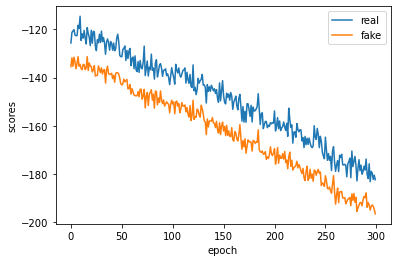

In [ ]:
plt.plot(real_scores)
plt.plot(fake_scores)
plt.xlabel("epoch")
plt.ylabel("scores")
plt.legend(['real', 'fake'])

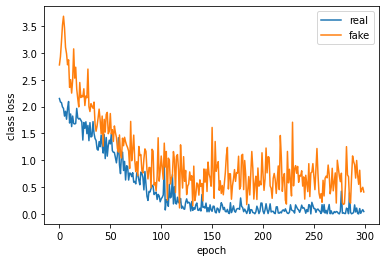

In [ ]:
plt.plot(real_cls_loss)
plt.plot(fake_cls_loss)

plt.xlabel("epoch")
plt.ylabel("class loss")
plt.legend(['real', 'fake'])

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [1/300], loss_g: 2.9714, loss_d: 3.2050, real_score: 0.8312, fake_score1: 0.2002, fake_score2: 0.1014
Saving generated-images-0001.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [2/300], loss_g: 3.6597, loss_d: 2.5545, real_score: 0.9113, fake_score1: 0.2622, fake_score2: 0.0854
Saving generated-images-0002.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [3/300], loss_g: 5.2773, loss_d: 2.9523, real_score: 0.8945, fake_score1: 0.4201, fake_score2: 0.0347
Saving generated-images-0003.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [4/300], loss_g: 3.0627, loss_d: 2.2371, real_score: 0.7129, fake_score1: 0.0657, fake_score2: 0.0760
Saving generated-images-0004.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [5/300], loss_g: 4.5625, loss_d: 2.2700, real_score: 0.7912, fake_score1: 0.2016, fake_score2: 0.0176
Saving generated-images-0005.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [6/300], loss_g: 3.6524, loss_d: 1.9408, real_score: 0.8359, fake_score1: 0.1156, fake_score2: 0.0395
Saving generated-images-0006.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [7/300], loss_g: 5.3868, loss_d: 2.1080, real_score: 0.9079, fake_score1: 0.2083, fake_score2: 0.0076
Saving generated-images-0007.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [8/300], loss_g: 4.8430, loss_d: 2.0990, real_score: 0.5387, fake_score1: 0.0021, fake_score2: 0.0168
Saving generated-images-0008.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [9/300], loss_g: 1.8138, loss_d: 2.0275, real_score: 0.4934, fake_score1: 0.0043, fake_score2: 0.2269
Saving generated-images-0009.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [10/300], loss_g: 3.5229, loss_d: 1.6146, real_score: 0.6538, fake_score1: 0.0240, fake_score2: 0.0471
Saving generated-images-0010.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [11/300], loss_g: 4.0292, loss_d: 1.0511, real_score: 0.9214, fake_score1: 0.1241, fake_score2: 0.0265
Saving generated-images-0011.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [12/300], loss_g: 5.2222, loss_d: 1.2723, real_score: 0.9453, fake_score1: 0.2137, fake_score2: 0.0118
Saving generated-images-0012.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [13/300], loss_g: 4.1220, loss_d: 0.9826, real_score: 0.9224, fake_score1: 0.1941, fake_score2: 0.0240
Saving generated-images-0013.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [14/300], loss_g: 4.5159, loss_d: 1.0317, real_score: 0.8560, fake_score1: 0.1298, fake_score2: 0.0199
Saving generated-images-0014.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [15/300], loss_g: 3.1958, loss_d: 1.1350, real_score: 0.9388, fake_score1: 0.1881, fake_score2: 0.0577
Saving generated-images-0015.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [16/300], loss_g: 4.8546, loss_d: 0.7126, real_score: 0.8853, fake_score1: 0.0551, fake_score2: 0.0143
Saving generated-images-0016.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [17/300], loss_g: 6.2759, loss_d: 0.8563, real_score: 0.9613, fake_score1: 0.2819, fake_score2: 0.0026
Saving generated-images-0017.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [18/300], loss_g: 5.8858, loss_d: 1.1232, real_score: 0.9242, fake_score1: 0.3452, fake_score2: 0.0046
Saving generated-images-0018.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [19/300], loss_g: 2.9857, loss_d: 0.8990, real_score: 0.6626, fake_score1: 0.0247, fake_score2: 0.1000
Saving generated-images-0019.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [20/300], loss_g: 6.6232, loss_d: 1.0891, real_score: 0.8942, fake_score1: 0.3161, fake_score2: 0.0021
Saving generated-images-0020.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [21/300], loss_g: 1.7676, loss_d: 0.9792, real_score: 0.6826, fake_score1: 0.1309, fake_score2: 0.2220
Saving generated-images-0021.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [22/300], loss_g: 6.0399, loss_d: 0.9046, real_score: 0.9563, fake_score1: 0.3668, fake_score2: 0.0038
Saving generated-images-0022.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [23/300], loss_g: 2.9365, loss_d: 0.8382, real_score: 0.8313, fake_score1: 0.0956, fake_score2: 0.0726
Saving generated-images-0023.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [24/300], loss_g: 4.4990, loss_d: 0.6929, real_score: 0.9300, fake_score1: 0.1868, fake_score2: 0.0192
Saving generated-images-0024.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [25/300], loss_g: 4.9374, loss_d: 0.3966, real_score: 0.9739, fake_score1: 0.0668, fake_score2: 0.0099
Saving generated-images-0025.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [26/300], loss_g: 5.6930, loss_d: 0.3940, real_score: 0.9472, fake_score1: 0.0191, fake_score2: 0.0059
Saving generated-images-0026.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [27/300], loss_g: 4.7863, loss_d: 0.3592, real_score: 0.9871, fake_score1: 0.0522, fake_score2: 0.0125
Saving generated-images-0027.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [28/300], loss_g: 5.4192, loss_d: 0.2603, real_score: 0.9383, fake_score1: 0.0363, fake_score2: 0.0061
Saving generated-images-0028.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [29/300], loss_g: 3.9065, loss_d: 0.6076, real_score: 0.6995, fake_score1: 0.0154, fake_score2: 0.0363
Saving generated-images-0029.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [30/300], loss_g: 4.1202, loss_d: 0.3431, real_score: 0.9839, fake_score1: 0.0922, fake_score2: 0.0234
Saving generated-images-0030.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [31/300], loss_g: 4.7448, loss_d: 0.4000, real_score: 0.9853, fake_score1: 0.1299, fake_score2: 0.0133
Saving generated-images-0031.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [32/300], loss_g: 4.3832, loss_d: 0.4890, real_score: 0.9687, fake_score1: 0.0878, fake_score2: 0.0160
Saving generated-images-0032.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [33/300], loss_g: 1.3230, loss_d: 0.6225, real_score: 0.7757, fake_score1: 0.0545, fake_score2: 0.3607
Saving generated-images-0033.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [34/300], loss_g: 5.2665, loss_d: 0.5240, real_score: 0.9145, fake_score1: 0.1931, fake_score2: 0.0072
Saving generated-images-0034.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [35/300], loss_g: 7.2475, loss_d: 0.5643, real_score: 0.9529, fake_score1: 0.2604, fake_score2: 0.0014
Saving generated-images-0035.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [36/300], loss_g: 12.5255, loss_d: 1.7143, real_score: 0.9942, fake_score1: 0.6592, fake_score2: 0.0000
Saving generated-images-0036.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [37/300], loss_g: 3.9486, loss_d: 0.3574, real_score: 0.9298, fake_score1: 0.1021, fake_score2: 0.0286
Saving generated-images-0037.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [38/300], loss_g: 4.3272, loss_d: 0.2839, real_score: 0.9286, fake_score1: 0.0424, fake_score2: 0.0210
Saving generated-images-0038.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [39/300], loss_g: 4.3790, loss_d: 0.5335, real_score: 0.8381, fake_score1: 0.1466, fake_score2: 0.0181
Saving generated-images-0039.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [40/300], loss_g: 3.9842, loss_d: 0.3313, real_score: 0.9101, fake_score1: 0.0806, fake_score2: 0.0260
Saving generated-images-0040.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [41/300], loss_g: 3.1926, loss_d: 0.4854, real_score: 0.9188, fake_score1: 0.0292, fake_score2: 0.0971
Saving generated-images-0041.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [42/300], loss_g: 2.0646, loss_d: 0.5222, real_score: 0.7204, fake_score1: 0.0318, fake_score2: 0.2016
Saving generated-images-0042.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [43/300], loss_g: 3.7792, loss_d: 0.2682, real_score: 0.9926, fake_score1: 0.0647, fake_score2: 0.0362
Saving generated-images-0043.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [44/300], loss_g: 1.1170, loss_d: 0.8186, real_score: 0.5988, fake_score1: 0.0645, fake_score2: 0.3966
Saving generated-images-0044.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [45/300], loss_g: 4.5068, loss_d: 0.2332, real_score: 0.9688, fake_score1: 0.0374, fake_score2: 0.0161
Saving generated-images-0045.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [46/300], loss_g: 5.2302, loss_d: 0.3243, real_score: 0.9676, fake_score1: 0.0454, fake_score2: 0.0095
Saving generated-images-0046.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [47/300], loss_g: 5.4126, loss_d: 0.3827, real_score: 0.9503, fake_score1: 0.0482, fake_score2: 0.0080
Saving generated-images-0047.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [48/300], loss_g: 4.5094, loss_d: 0.3510, real_score: 0.8925, fake_score1: 0.1101, fake_score2: 0.0176
Saving generated-images-0048.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [49/300], loss_g: 4.1086, loss_d: 0.2777, real_score: 0.9350, fake_score1: 0.0200, fake_score2: 0.0239
Saving generated-images-0049.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [50/300], loss_g: 4.8273, loss_d: 0.4963, real_score: 0.8927, fake_score1: 0.0510, fake_score2: 0.0143
Saving generated-images-0050.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [51/300], loss_g: 9.3272, loss_d: 2.1468, real_score: 0.9995, fake_score1: 0.7880, fake_score2: 0.0002
Saving generated-images-0051.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [52/300], loss_g: 4.1951, loss_d: 0.2735, real_score: 0.9879, fake_score1: 0.0647, fake_score2: 0.0248
Saving generated-images-0052.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [53/300], loss_g: 2.6359, loss_d: 0.4633, real_score: 0.8039, fake_score1: 0.0439, fake_score2: 0.1049
Saving generated-images-0053.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [54/300], loss_g: 3.4357, loss_d: 0.5083, real_score: 0.9310, fake_score1: 0.0825, fake_score2: 0.0492
Saving generated-images-0054.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [55/300], loss_g: 0.2304, loss_d: 1.3104, real_score: 0.4159, fake_score1: 0.0184, fake_score2: 0.8352
Saving generated-images-0055.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [56/300], loss_g: 2.7397, loss_d: 0.5844, real_score: 0.7933, fake_score1: 0.1306, fake_score2: 0.0803
Saving generated-images-0056.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [57/300], loss_g: 4.3350, loss_d: 0.4373, real_score: 0.8769, fake_score1: 0.1788, fake_score2: 0.0227
Saving generated-images-0057.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [58/300], loss_g: 4.5527, loss_d: 0.4044, real_score: 0.9475, fake_score1: 0.1810, fake_score2: 0.0151
Saving generated-images-0058.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [59/300], loss_g: 3.5487, loss_d: 1.1223, real_score: 0.4363, fake_score1: 0.0007, fake_score2: 0.0594
Saving generated-images-0059.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [60/300], loss_g: 4.9162, loss_d: 0.1918, real_score: 0.9362, fake_score1: 0.0379, fake_score2: 0.0127
Saving generated-images-0060.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [61/300], loss_g: 5.3303, loss_d: 0.2528, real_score: 0.9336, fake_score1: 0.0143, fake_score2: 0.0080
Saving generated-images-0061.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [62/300], loss_g: 2.7037, loss_d: 0.3977, real_score: 0.8685, fake_score1: 0.0638, fake_score2: 0.1010
Saving generated-images-0062.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [63/300], loss_g: 1.6034, loss_d: 0.6918, real_score: 0.7205, fake_score1: 0.0602, fake_score2: 0.2764
Saving generated-images-0063.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [64/300], loss_g: 4.3580, loss_d: 0.3196, real_score: 0.9836, fake_score1: 0.1408, fake_score2: 0.0215
Saving generated-images-0064.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [65/300], loss_g: 3.2649, loss_d: 0.5004, real_score: 0.8449, fake_score1: 0.1485, fake_score2: 0.0585
Saving generated-images-0065.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [66/300], loss_g: 4.3526, loss_d: 0.2516, real_score: 0.9729, fake_score1: 0.0242, fake_score2: 0.0212
Saving generated-images-0066.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [67/300], loss_g: 5.3164, loss_d: 0.4574, real_score: 0.9984, fake_score1: 0.2472, fake_score2: 0.0070
Saving generated-images-0067.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [68/300], loss_g: 3.9053, loss_d: 0.8324, real_score: 0.8182, fake_score1: 0.0128, fake_score2: 0.0811
Saving generated-images-0068.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [69/300], loss_g: 4.5169, loss_d: 0.1901, real_score: 0.9725, fake_score1: 0.0264, fake_score2: 0.0194
Saving generated-images-0069.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [70/300], loss_g: 3.2164, loss_d: 0.1652, real_score: 0.9767, fake_score1: 0.0381, fake_score2: 0.0662
Saving generated-images-0070.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [71/300], loss_g: 1.2174, loss_d: 1.1818, real_score: 0.4743, fake_score1: 0.0457, fake_score2: 0.4061
Saving generated-images-0071.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [72/300], loss_g: 2.6433, loss_d: 0.4103, real_score: 0.7859, fake_score1: 0.0485, fake_score2: 0.1069
Saving generated-images-0072.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [73/300], loss_g: 4.1096, loss_d: 0.5194, real_score: 0.9858, fake_score1: 0.2259, fake_score2: 0.0324
Saving generated-images-0073.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [74/300], loss_g: 7.6470, loss_d: 0.2300, real_score: 0.9413, fake_score1: 0.0135, fake_score2: 0.0013
Saving generated-images-0074.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [75/300], loss_g: 4.3285, loss_d: 0.1135, real_score: 0.9871, fake_score1: 0.0390, fake_score2: 0.0223
Saving generated-images-0075.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [76/300], loss_g: 2.3424, loss_d: 0.5464, real_score: 0.7460, fake_score1: 0.0674, fake_score2: 0.1528
Saving generated-images-0076.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [77/300], loss_g: 3.8459, loss_d: 1.1437, real_score: 0.4961, fake_score1: 0.0021, fake_score2: 0.0445
Saving generated-images-0077.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [78/300], loss_g: 3.6656, loss_d: 0.6897, real_score: 0.8103, fake_score1: 0.1988, fake_score2: 0.0445
Saving generated-images-0078.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [79/300], loss_g: 4.0879, loss_d: 0.3924, real_score: 0.8961, fake_score1: 0.0288, fake_score2: 0.0363
Saving generated-images-0079.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [80/300], loss_g: 5.5489, loss_d: 0.2341, real_score: 0.9894, fake_score1: 0.0557, fake_score2: 0.0062
Saving generated-images-0080.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [81/300], loss_g: 0.8075, loss_d: 1.0340, real_score: 0.5260, fake_score1: 0.0398, fake_score2: 0.5701
Saving generated-images-0081.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [82/300], loss_g: 2.2622, loss_d: 0.6745, real_score: 0.7561, fake_score1: 0.1019, fake_score2: 0.1430
Saving generated-images-0082.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [83/300], loss_g: 3.5272, loss_d: 0.2387, real_score: 0.9168, fake_score1: 0.0571, fake_score2: 0.0421
Saving generated-images-0083.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [84/300], loss_g: 5.1507, loss_d: 0.2347, real_score: 0.9344, fake_score1: 0.0140, fake_score2: 0.0111
Saving generated-images-0084.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [85/300], loss_g: 3.8183, loss_d: 0.3638, real_score: 0.8907, fake_score1: 0.0409, fake_score2: 0.0382
Saving generated-images-0085.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [86/300], loss_g: 3.9120, loss_d: 0.2260, real_score: 0.9419, fake_score1: 0.0291, fake_score2: 0.0316
Saving generated-images-0086.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [87/300], loss_g: 5.0278, loss_d: 0.4439, real_score: 0.8923, fake_score1: 0.0370, fake_score2: 0.0127
Saving generated-images-0087.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [88/300], loss_g: 5.3326, loss_d: 0.2506, real_score: 0.9201, fake_score1: 0.0074, fake_score2: 0.0158
Saving generated-images-0088.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [89/300], loss_g: 4.3922, loss_d: 0.2132, real_score: 0.9932, fake_score1: 0.0748, fake_score2: 0.0203
Saving generated-images-0089.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [90/300], loss_g: 11.0262, loss_d: 4.7312, real_score: 0.9997, fake_score1: 0.9635, fake_score2: 0.0003
Saving generated-images-0090.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [91/300], loss_g: 5.0049, loss_d: 0.4035, real_score: 0.9768, fake_score1: 0.1043, fake_score2: 0.0103
Saving generated-images-0091.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [92/300], loss_g: 5.3344, loss_d: 0.1864, real_score: 0.9857, fake_score1: 0.0696, fake_score2: 0.0115
Saving generated-images-0092.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [93/300], loss_g: 1.9989, loss_d: 0.5363, real_score: 0.6893, fake_score1: 0.0079, fake_score2: 0.2024
Saving generated-images-0093.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [94/300], loss_g: 7.6131, loss_d: 0.8416, real_score: 0.9986, fake_score1: 0.4152, fake_score2: 0.0009
Saving generated-images-0094.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [95/300], loss_g: 6.0760, loss_d: 0.3136, real_score: 0.9695, fake_score1: 0.1298, fake_score2: 0.0046
Saving generated-images-0095.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [96/300], loss_g: 1.6327, loss_d: 7.2044, real_score: 0.0186, fake_score1: 0.0000, fake_score2: 0.4517
Saving generated-images-0096.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [97/300], loss_g: 6.5389, loss_d: 0.1935, real_score: 0.9839, fake_score1: 0.0071, fake_score2: 0.0043
Saving generated-images-0097.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [98/300], loss_g: 4.0135, loss_d: 0.1802, real_score: 0.9449, fake_score1: 0.0575, fake_score2: 0.0313
Saving generated-images-0098.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [99/300], loss_g: 4.8379, loss_d: 0.1546, real_score: 0.9576, fake_score1: 0.0115, fake_score2: 0.0126
Saving generated-images-0099.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [100/300], loss_g: 3.4639, loss_d: 0.4732, real_score: 0.8234, fake_score1: 0.0315, fake_score2: 0.0686
Saving generated-images-0100.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [101/300], loss_g: 5.9861, loss_d: 0.7731, real_score: 0.8841, fake_score1: 0.3513, fake_score2: 0.0045
Saving generated-images-0101.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [102/300], loss_g: 6.5995, loss_d: 0.2558, real_score: 0.9798, fake_score1: 0.1513, fake_score2: 0.0034
Saving generated-images-0102.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [103/300], loss_g: 9.6603, loss_d: 0.4820, real_score: 0.9913, fake_score1: 0.2852, fake_score2: 0.0001
Saving generated-images-0103.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [104/300], loss_g: 5.0616, loss_d: 0.2129, real_score: 0.9933, fake_score1: 0.0662, fake_score2: 0.0096
Saving generated-images-0104.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [105/300], loss_g: 4.6571, loss_d: 0.2756, real_score: 0.9918, fake_score1: 0.0816, fake_score2: 0.0159
Saving generated-images-0105.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [106/300], loss_g: 4.7110, loss_d: 0.4077, real_score: 0.8585, fake_score1: 0.0132, fake_score2: 0.0200
Saving generated-images-0106.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [107/300], loss_g: 1.3610, loss_d: 0.5025, real_score: 0.6928, fake_score1: 0.0200, fake_score2: 0.3788
Saving generated-images-0107.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [108/300], loss_g: 4.4658, loss_d: 0.1159, real_score: 0.9776, fake_score1: 0.0314, fake_score2: 0.0203
Saving generated-images-0108.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [109/300], loss_g: 5.8712, loss_d: 0.2421, real_score: 0.9518, fake_score1: 0.0463, fake_score2: 0.0062
Saving generated-images-0109.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [110/300], loss_g: 1.3401, loss_d: 0.6707, real_score: 0.6545, fake_score1: 0.0191, fake_score2: 0.3701
Saving generated-images-0110.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [111/300], loss_g: 4.0975, loss_d: 0.4915, real_score: 0.9985, fake_score1: 0.1990, fake_score2: 0.0243
Saving generated-images-0111.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [112/300], loss_g: 1.9278, loss_d: 1.0151, real_score: 0.5063, fake_score1: 0.0027, fake_score2: 0.2720
Saving generated-images-0112.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [113/300], loss_g: 1.4067, loss_d: 0.8346, real_score: 0.6048, fake_score1: 0.0597, fake_score2: 0.3521
Saving generated-images-0113.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [114/300], loss_g: 5.3839, loss_d: 0.2138, real_score: 0.8799, fake_score1: 0.0236, fake_score2: 0.0096
Saving generated-images-0114.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [115/300], loss_g: 5.8001, loss_d: 0.3797, real_score: 0.9996, fake_score1: 0.1934, fake_score2: 0.0053
Saving generated-images-0115.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [116/300], loss_g: 3.9286, loss_d: 0.2490, real_score: 0.9275, fake_score1: 0.0636, fake_score2: 0.0295
Saving generated-images-0116.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [117/300], loss_g: 5.5088, loss_d: 0.2418, real_score: 0.9991, fake_score1: 0.1165, fake_score2: 0.0068
Saving generated-images-0117.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [118/300], loss_g: 5.3171, loss_d: 0.2631, real_score: 0.9620, fake_score1: 0.0270, fake_score2: 0.0105
Saving generated-images-0118.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [119/300], loss_g: 14.1880, loss_d: 1.8256, real_score: 0.9890, fake_score1: 0.7248, fake_score2: 0.0000
Saving generated-images-0119.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [120/300], loss_g: 4.8377, loss_d: 0.1341, real_score: 0.9278, fake_score1: 0.0133, fake_score2: 0.0166
Saving generated-images-0120.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [121/300], loss_g: 3.1495, loss_d: 1.2975, real_score: 0.4436, fake_score1: 0.0018, fake_score2: 0.0916
Saving generated-images-0121.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [122/300], loss_g: 1.2319, loss_d: 1.0361, real_score: 0.4954, fake_score1: 0.0314, fake_score2: 0.3992
Saving generated-images-0122.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [123/300], loss_g: 5.9685, loss_d: 0.4447, real_score: 0.9931, fake_score1: 0.2651, fake_score2: 0.0057
Saving generated-images-0123.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [124/300], loss_g: 5.2627, loss_d: 0.0496, real_score: 0.9964, fake_score1: 0.0165, fake_score2: 0.0123
Saving generated-images-0124.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [125/300], loss_g: 5.5216, loss_d: 0.8196, real_score: 0.9848, fake_score1: 0.2884, fake_score2: 0.0085
Saving generated-images-0125.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [126/300], loss_g: 5.5535, loss_d: 0.1398, real_score: 0.9660, fake_score1: 0.0155, fake_score2: 0.0077
Saving generated-images-0126.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [127/300], loss_g: 6.2859, loss_d: 0.3707, real_score: 0.9998, fake_score1: 0.2217, fake_score2: 0.0030
Saving generated-images-0127.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [128/300], loss_g: 5.5574, loss_d: 0.1062, real_score: 0.9926, fake_score1: 0.0334, fake_score2: 0.0097
Saving generated-images-0128.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [129/300], loss_g: 0.3779, loss_d: 1.0802, real_score: 0.5106, fake_score1: 0.0283, fake_score2: 0.7600
Saving generated-images-0129.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [130/300], loss_g: 5.1967, loss_d: 0.1081, real_score: 0.9978, fake_score1: 0.0213, fake_score2: 0.0103
Saving generated-images-0130.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [131/300], loss_g: 4.0041, loss_d: 0.2393, real_score: 0.9696, fake_score1: 0.0705, fake_score2: 0.0311
Saving generated-images-0131.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [132/300], loss_g: 3.2680, loss_d: 0.4035, real_score: 0.7608, fake_score1: 0.0107, fake_score2: 0.0625
Saving generated-images-0132.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [133/300], loss_g: 4.9034, loss_d: 0.2215, real_score: 0.9988, fake_score1: 0.0187, fake_score2: 0.0138
Saving generated-images-0133.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [134/300], loss_g: 5.2006, loss_d: 0.0972, real_score: 0.9944, fake_score1: 0.0192, fake_score2: 0.0109
Saving generated-images-0134.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [135/300], loss_g: 4.0963, loss_d: 0.4728, real_score: 0.9958, fake_score1: 0.1048, fake_score2: 0.0259
Saving generated-images-0135.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [136/300], loss_g: 6.2755, loss_d: 0.1652, real_score: 0.9751, fake_score1: 0.0080, fake_score2: 0.0076
Saving generated-images-0136.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [137/300], loss_g: 4.9146, loss_d: 0.1524, real_score: 0.9777, fake_score1: 0.0817, fake_score2: 0.0131
Saving generated-images-0137.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [138/300], loss_g: 6.2511, loss_d: 0.3173, real_score: 0.9759, fake_score1: 0.1331, fake_score2: 0.0031
Saving generated-images-0138.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [139/300], loss_g: 6.1411, loss_d: 0.2625, real_score: 0.9739, fake_score1: 0.0630, fake_score2: 0.0036
Saving generated-images-0139.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [140/300], loss_g: 6.1480, loss_d: 0.1688, real_score: 0.9992, fake_score1: 0.0164, fake_score2: 0.0040
Saving generated-images-0140.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [141/300], loss_g: 5.2843, loss_d: 0.4276, real_score: 0.9944, fake_score1: 0.1256, fake_score2: 0.0082
Saving generated-images-0141.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [142/300], loss_g: 2.0309, loss_d: 0.3614, real_score: 0.7714, fake_score1: 0.0144, fake_score2: 0.2137
Saving generated-images-0142.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [143/300], loss_g: 5.7270, loss_d: 0.2159, real_score: 0.8915, fake_score1: 0.0055, fake_score2: 0.0126
Saving generated-images-0143.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [144/300], loss_g: 5.7046, loss_d: 0.0864, real_score: 0.9954, fake_score1: 0.0154, fake_score2: 0.0057
Saving generated-images-0144.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [145/300], loss_g: 6.4266, loss_d: 0.3399, real_score: 0.9704, fake_score1: 0.0836, fake_score2: 0.0052
Saving generated-images-0145.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [146/300], loss_g: 4.5252, loss_d: 0.1307, real_score: 0.9788, fake_score1: 0.0527, fake_score2: 0.0193
Saving generated-images-0146.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [147/300], loss_g: 0.0502, loss_d: 2.1487, real_score: 0.2415, fake_score1: 0.0194, fake_score2: 0.9674
Saving generated-images-0147.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [148/300], loss_g: 2.9252, loss_d: 0.2943, real_score: 0.8253, fake_score1: 0.0252, fake_score2: 0.0975
Saving generated-images-0148.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [149/300], loss_g: 4.9496, loss_d: 0.1103, real_score: 0.9967, fake_score1: 0.0398, fake_score2: 0.0134
Saving generated-images-0149.png


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:2899: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Epoch [150/300], loss_g: 3.2251, loss_d: 0.2912, real_score: 0.8160, fake_score1: 0.0108, fake_score2: 0.0780
Saving generated-images-0150.png


  0%|          | 0/141 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 5.2201, loss_d: 0.4484, real_score: 0.9128, fake_score: 0.2712
Saving generated-images-0001.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 9.7153, loss_d: 0.1475, real_score: 0.8944, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 1.9997, loss_d: 0.4637, real_score: 0.7904, fake_score: 0.1718
Saving generated-images-0003.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.6564, loss_d: 0.5815, real_score: 0.6361, fake_score: 0.0657
Saving generated-images-0004.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 1.3577, loss_d: 1.2996, real_score: 0.4214, fake_score: 0.1102
Saving generated-images-0005.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 2.2438, loss_d: 1.2267, real_score: 0.3557, fake_score: 0.0209
Saving generated-images-0006.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 5.6926, loss_d: 0.4680, real_score: 0.9477, fake_score: 0.3081
Saving generated-images-0007.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 7.2376, loss_d: 0.6261, real_score: 0.9584, fake_score: 0.3819
Saving generated-images-0008.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 3.3911, loss_d: 0.3845, real_score: 0.8937, fake_score: 0.2125
Saving generated-images-0009.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 2.8853, loss_d: 1.1189, real_score: 0.4034, fake_score: 0.0214
Saving generated-images-0010.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 4.2427, loss_d: 0.5988, real_score: 0.8232, fake_score: 0.2996
Saving generated-images-0011.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 6.8189, loss_d: 0.1027, real_score: 0.9213, fake_score: 0.0154
Saving generated-images-0012.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 3.2058, loss_d: 0.2451, real_score: 0.9151, fake_score: 0.1292
Saving generated-images-0013.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 2.0082, loss_d: 0.5816, real_score: 0.6442, fake_score: 0.0973
Saving generated-images-0014.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 1.8383, loss_d: 0.6129, real_score: 0.6621, fake_score: 0.1139
Saving generated-images-0015.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 4.5336, loss_d: 0.3866, real_score: 0.9054, fake_score: 0.2230
Saving generated-images-0016.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 0.7947, loss_d: 0.6861, real_score: 0.5938, fake_score: 0.0892
Saving generated-images-0017.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 5.2185, loss_d: 0.2239, real_score: 0.8778, fake_score: 0.0761
Saving generated-images-0018.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 4.5996, loss_d: 0.2144, real_score: 0.9211, fake_score: 0.1173
Saving generated-images-0019.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 2.3336, loss_d: 0.3259, real_score: 0.9372, fake_score: 0.2022
Saving generated-images-0020.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 4.9631, loss_d: 0.2918, real_score: 0.9612, fake_score: 0.1962
Saving generated-images-0021.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 3.5806, loss_d: 0.1732, real_score: 0.9245, fake_score: 0.0834
Saving generated-images-0022.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 3.5742, loss_d: 0.7454, real_score: 0.9282, fake_score: 0.4543
Saving generated-images-0023.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 0.3757, loss_d: 1.5886, real_score: 0.2595, fake_score: 0.0058
Saving generated-images-0024.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.5567, loss_d: 0.4531, real_score: 0.6958, fake_score: 0.0365
Saving generated-images-0025.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 3.6361, loss_d: 0.3233, real_score: 0.7706, fake_score: 0.0391
Saving generated-images-0026.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 2.4176, loss_d: 0.3365, real_score: 0.9405, fake_score: 0.2153
Saving generated-images-0027.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 3.7566, loss_d: 0.2688, real_score: 0.8724, fake_score: 0.1100
Saving generated-images-0028.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 0.2233, loss_d: 1.1264, real_score: 0.4280, fake_score: 0.0360
Saving generated-images-0029.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 2.9838, loss_d: 0.3907, real_score: 0.9500, fake_score: 0.2526
Saving generated-images-0030.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 1.9911, loss_d: 0.4758, real_score: 0.7102, fake_score: 0.0681
Saving generated-images-0031.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 1.3204, loss_d: 0.7762, real_score: 0.5094, fake_score: 0.0340
Saving generated-images-0032.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 1.8967, loss_d: 0.2521, real_score: 0.8669, fake_score: 0.0849
Saving generated-images-0033.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 2.6165, loss_d: 0.1814, real_score: 0.9615, fake_score: 0.1212
Saving generated-images-0034.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 4.9115, loss_d: 0.0668, real_score: 0.9868, fake_score: 0.0503
Saving generated-images-0035.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 0.9595, loss_d: 0.5363, real_score: 0.6833, fake_score: 0.0800
Saving generated-images-0036.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 1.5380, loss_d: 0.4757, real_score: 0.7046, fake_score: 0.0567
Saving generated-images-0037.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 7.6248, loss_d: 0.7351, real_score: 0.9486, fake_score: 0.4537
Saving generated-images-0038.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 6.0469, loss_d: 1.0996, real_score: 0.9927, fake_score: 0.5634
Saving generated-images-0039.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 5.6443, loss_d: 0.2869, real_score: 0.7850, fake_score: 0.0160
Saving generated-images-0040.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 3.8869, loss_d: 0.2156, real_score: 0.8701, fake_score: 0.0627
Saving generated-images-0041.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 6.9790, loss_d: 0.9832, real_score: 0.9227, fake_score: 0.4951
Saving generated-images-0042.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 2.9469, loss_d: 0.3163, real_score: 0.7883, fake_score: 0.0587
Saving generated-images-0043.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 6.2024, loss_d: 0.4819, real_score: 0.8633, fake_score: 0.2509
Saving generated-images-0044.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 2.9537, loss_d: 0.0996, real_score: 0.9470, fake_score: 0.0421
Saving generated-images-0045.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 0.9038, loss_d: 0.4491, real_score: 0.6848, fake_score: 0.0375
Saving generated-images-0046.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 0.3118, loss_d: 1.4356, real_score: 0.3721, fake_score: 0.1642
Saving generated-images-0047.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 4.8191, loss_d: 0.2191, real_score: 0.8381, fake_score: 0.0313
Saving generated-images-0048.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 0.2835, loss_d: 1.1292, real_score: 0.3952, fake_score: 0.0164
Saving generated-images-0049.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 3.5823, loss_d: 0.7616, real_score: 0.8415, fake_score: 0.3714
Saving generated-images-0050.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 2.9252, loss_d: 0.3374, real_score: 0.7737, fake_score: 0.0421
Saving generated-images-0051.png


  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

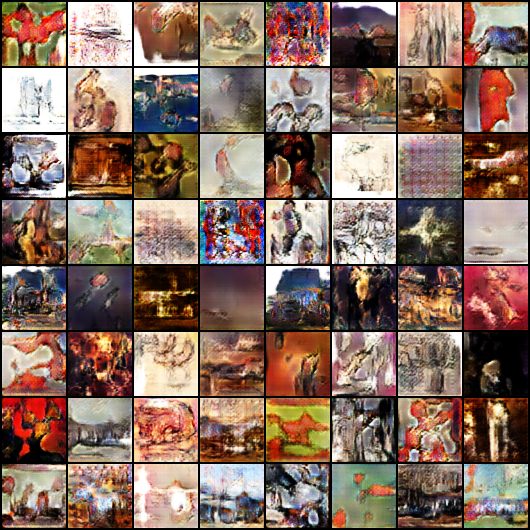

In [ ]:
Image('0318_generated_plots/generated-images-0050.png')

In [ ]:
loss_g, losses_d, real_scores, fake_scores = history